In [1]:
import requests
import matplotlib.pyplot as plt
import pandas as pd
import mpld3
from mpld3 import plugins
import os
from datetime import datetime,date,timedelta,time
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import pandas as pd
from sqlalchemy import create_engine, types, text

In [2]:
def get_fear_greed_data(limit=30):
    url = f"https://api.alternative.me/fng/?limit={limit}&format=json&date_format=us"
    response = requests.get(url)
    data = response.json()["data"]
    # Convert the data into a DataFrame``
    fear_greed_df = pd.DataFrame(data)
    fear_greed_df['date'] = pd.to_datetime(fear_greed_df['timestamp']).dt.date
    fear_greed_df['value'] = fear_greed_df['value'].astype(int)
    return fear_greed_df[['date','value_classification' ,'value']]

In [3]:

# Replace with your actual CoinAPI key
#api_key = os.environ.get("COINAPI_KEY")
api_key = '44321bcd-b97e-4fdd-8098-f114eed3fba7'

def get_real_time_price(symbol, api_key):
    base_url = "https://rest.coinapi.io/v1/exchangerate"
    url = f"{base_url}/{symbol}/USD"
    headers = {
        "X-CoinAPI-Key": api_key
    }
    response = requests.get(url, headers=headers)
    data = response.json()
    
    if 'rate' in data:
        return data['rate']
    else:
        print(f"Error fetching real-time price: {data}")
        return None

def get_historical_price_data(symbol, start_date, end_date, api_key):
    base_url = "https://rest.coinapi.io/v1/exchangerate"
    url = f"{base_url}/{symbol}/USD/history"
    
    headers = {
        "X-CoinAPI-Key": api_key
    }
    
    params = {
        "period_id": "30MIN", # get data every 30 minutes
        "time_start": start_date.isoformat(),
        "time_end": end_date.isoformat(),
        "limit": 100000
    }
    
    response = requests.get(url, headers=headers, params=params)
    data = response.json()
    
    if not isinstance(data, list) or len(data) == 0:
        print(f"Unexpected API response: {data}")
        return pd.DataFrame(columns=['date', 'daily_min_price', 'daily_max_price', 'daily_avg_price'])
    
    df = pd.DataFrame(data)

    df['date'] = pd.to_datetime(df['date'])

    return df

def transform_price_data(df):
    # print(df.head())
    df['date'] = pd.to_datetime(df['time_period_start']).dt.date
    df = df.rename(columns={'rate_open':'daily_open_price','rate_close':'daily_close_price','rate_low': 'daily_min_price', 'rate_high': 'daily_max_price'})
    df = df[['date', 'daily_open_price','daily_close_price','daily_min_price', 'daily_max_price']]
    print(df.head())
    df['daily_avg_price'] = (df['daily_min_price'] + df['daily_max_price']) / 2
    df['daily_change'] = (df['daily_close_price'] - df['daily_open_price']) / df['daily_open_price']
    print(df.head())

    # Calculate weekly change
    df['weekly_change'] = df['daily_close_price'].pct_change(periods=7)
    # Calculate the change between Monday and Friday in the current week
    df['weekday'] = pd.to_datetime(df['date']).dt.weekday
    df['week'] = pd.to_datetime(df['date']).dt.isocalendar().week
    df['year'] = pd.to_datetime(df['date']).dt.year

    # Group by year and week
    weekly_groups = df.groupby(['year', 'week'])

    # Initialize a list to store the weekly changes
    weekly_changes = []

    for (year, week), group in weekly_groups:
        monday_price = group[group['weekday'] == 0]['daily_close_price']
        friday_price = group[group['weekday'] == 4]['daily_close_price']
        
        if not monday_price.empty and not friday_price.empty:
            weekly_change = (friday_price.values[0] - monday_price.values[0]) / monday_price.values[0]
            weekly_changes.append({'year': year, 'week': week, 'weekly_change': weekly_change})

    # Convert the list to a DataFrame
    weekly_change_df = pd.DataFrame(weekly_changes)

    # Merge the weekly changes back to the original DataFrame
    df = df.merge(weekly_change_df, on=['year', 'week'], how='left')

    rt_price = get_real_time_price(symbol, api_key)
    rt_df = pd.DataFrame({
    'date': [pd.to_datetime('now').date()],  # Use current date
    'daily_open_price': [rt_price],    # Assuming open and close are the same for real-time
    'daily_close_price': [rt_price],
    'daily_change': [0],
    'daily_avg_price': [rt_price],    # Use the real-time price
    'daily_min_price': [rt_price],     # Assuming min and max are the same for real-time
    'daily_max_price': [rt_price]
    })

    # print(rt_df.head())

    # Join the real-time price DataFrame with historical
    df = pd.concat([df, rt_df], ignore_index=True)

    # Optionally, sort the DataFrame by date
    df.sort_values('date', ascending=True, inplace=True)

    # generate utility columns

    # Initialize current max price
    current_max_price = 0
    # List to store the price ratios
    price_ratios = []
    max_prices = []

    # Calculate price ratios
    for index, row in df.iterrows():
        daily_avg_price = row['daily_avg_price']
        
        # Update current max price
        current_max_price = max(current_max_price, daily_avg_price)      
        # Calculate the ratio
        price_ratio = (daily_avg_price - current_max_price) / current_max_price
        price_ratios.append(price_ratio)
        max_prices.append(current_max_price)
    # Add the price ratios to the DataFrame

    df['price_ratio'] = price_ratios
    df['current_max_price'] = max_prices  # Add current max price as a new column

 
    
    df['MA_30'] = df['daily_avg_price'].rolling(window=30).mean()
    df['MA_60'] = df['daily_avg_price'].rolling(window=60).mean()
    df['MA_90'] = df['daily_avg_price'].rolling(window=90).mean()
    df['MA_120'] = df['daily_avg_price'].rolling(window=120).mean()
    df['MA_150'] = df['daily_avg_price'].rolling(window=150).mean()
    df['MA_180'] = df['daily_avg_price'].rolling(window=180).mean()
    # df['MA125_ratio'] = (df['MA_125']- df['daily_avg_price']) / df['daily_avg_price']
    df['MA30_ratio'] = (df['MA_30']- df['daily_avg_price']) / df['daily_avg_price']
    df['MA60_ratio'] = (df['MA_60'] - df['daily_avg_price']) / df['daily_avg_price']
    df['MA90_ratio'] = (df['MA_90'] - df['daily_avg_price']) / df['daily_avg_price']
    df['MA120_ratio'] = (df['MA_120'] - df['daily_avg_price']) / df['daily_avg_price']
    df['MA150_ratio'] = (df['MA_150'] - df['daily_avg_price']) / df['daily_avg_price']
    df['MA180_ratio'] = (df['MA_180'] - df['daily_avg_price']) / df['daily_avg_price']
    return df[['date','daily_open_price','daily_close_price','daily_change', 'daily_min_price', 'daily_max_price', 'daily_avg_price','current_max_price','price_ratio','MA_30','MA_60','MA_90','MA_120','MA_150','MA_180', \
    'MA30_ratio', 'MA60_ratio','MA90_ratio','MA120_ratio','MA150_ratio','MA180_ratio']]


def get_price_data(symbol,start_date):
    end_date = date.today()
    return get_historical_price_data(symbol, start_date, end_date, api_key)

In [46]:

def transform_price_data_daily(df):
    """
    Transform 30-minute Bitcoin price data into daily statistics aligned with US market hours.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame with 30-min Bitcoin price data in UTC
    
    Returns:
    pd.DataFrame: Daily statistics including market open/close prices and daily averages
    """
    # Convert timestamps to datetime if they aren't already
    df['time_open'] = pd.to_datetime(df['time_open'])
    df['time_close'] = pd.to_datetime(df['time_close'])
    
    # Check if timestamps are already timezone aware
    is_tz_aware = df['time_open'].dt.tz is not None
    
    # Convert timestamps to US Eastern time
    if is_tz_aware:
        # If already tz-aware, just convert
        df['time_open_et'] = df['time_open'].dt.tz_convert('US/Eastern')
        df['time_close_et'] = df['time_close'].dt.tz_convert('US/Eastern')
    else:
        # If not tz-aware, localize first
        df['time_open_et'] = df['time_open'].dt.tz_localize('UTC').dt.tz_convert('US/Eastern')
        df['time_close_et'] = df['time_close'].dt.tz_localize('UTC').dt.tz_convert('US/Eastern')
    
    # Add date column for grouping
    df['date'] = df['time_open_et'].dt.date
    
    # Create daily summary DataFrame
    daily_data = []
    
    for date, group in df.groupby('date'):
        # Convert date to datetime for proper comparison
        date_dt = pd.to_datetime(date)
        
        # Define market hours for this date
        market_open = pd.Timestamp.combine(date_dt.date(), time(9, 30)).tz_localize('US/Eastern')
        market_close = pd.Timestamp.combine(date_dt.date(), time(16, 0)).tz_localize('US/Eastern')
        
        # Find closest data points to market open and close
        open_price_row = group[
            (group['time_open_et'] <= market_open) & 
            (group['time_close_et'] >= market_open)
        ]
        
        close_price_row = group[
            (group['time_open_et'] <= market_close) & 
            (group['time_close_et'] >= market_close)
        ]
        
        # Handle edge cases where rows might be empty
        market_open_price = None
        market_close_price = None
        market_open_timestamp = None
        market_close_timestamp = None
        
        if not open_price_row.empty:
            market_open_price = open_price_row['rate_open'].iloc[0]
            market_open_timestamp = market_open
        else:
            # Find closest point before market open
            before_open = group[group['time_open_et'] <= market_open]
            if not before_open.empty:
                market_open_price = before_open.iloc[-1]['rate_close']
                market_open_timestamp = before_open.iloc[-1]['time_close_et']
        
        if not close_price_row.empty:
            market_close_price = close_price_row['rate_close'].iloc[0]
            market_close_timestamp = market_close
        else:
            # Find closest point after market close
            after_close = group[group['time_close_et'] >= market_close]
            if not after_close.empty:
                market_close_price = after_close.iloc[0]['rate_open']
                market_close_timestamp = after_close.iloc[0]['time_open_et']
        
        daily_stats = {
            'date': date,
            'market_open_price': market_open_price,
            'market_open_timestamp': market_open_timestamp,
            'market_close_price': market_close_price,
            'market_close_timestamp': market_close_timestamp,
            'avg_price': group['rate_close'].mean(),
            'daily_high': group['rate_high'].max(),
            'daily_low': group['rate_low'].min(),
        }
        
        daily_data.append(daily_stats)
    
    # Create final DataFrame
    if not daily_data:
        return pd.DataFrame()
    
    daily_df = pd.DataFrame(daily_data)
    daily_df['date'] = pd.to_datetime(daily_df['date'])

    # Calculate daily price change
    daily_df['daily_price_change'] = (
        (daily_df['daily_high'] - daily_df['daily_low']) / 
        daily_df['daily_low']
    ).round(2)

    # Calculate daily market price change 
    daily_df['market_price_change'] = (
        (daily_df['market_close_price'] - daily_df['market_open_price']) / 
        daily_df['market_open_price']
    ).round(2)
    # Drop rows where market_open_price is NaN
    daily_df = daily_df.dropna(subset=['market_open_price'])

    # generate the monday to friday change

    # Extract the weekday (0=Monday, 4=Friday)
    daily_df['weekday'] = daily_df['date'].dt.weekday

    # Initialize a new column for the price change between Monday and Friday
    daily_df['monday_price'] = None
    daily_df['friday_price'] = None
    daily_df['monday_to_friday_change'] = None

# Iterate through the DataFrame to calculate the price change
    for i in range(len(daily_df) - 4):
        if daily_df.iloc[i]['weekday'] == 0:  # If it's a Monday
            monday_price = daily_df.iloc[i]['market_open_price']
            friday_price = daily_df.iloc[i+4]['market_close_price']
            price_change = (friday_price - monday_price) / monday_price
            daily_df.at[i, 'monday_price'] = monday_price
            daily_df.at[i, 'friday_price'] = friday_price
            daily_df.at[i+4, 'monday_to_friday_change'] = price_change

    
    return daily_df

In [5]:
bitcoin_df_1 = get_historical_price_data("BTC", pd.to_datetime('2025-04-10'), date.today(), api_key)

# bitcoin_df = bitcoin_df[bitcoin_df['date'] >= '2022-01-01']
# bitcoin_df = bitcoin_df[bitcoin_df['date'] >= '2022-01-01']
# bitcoin_df.sort_values('date',ascending=True).head(20)
# bitcoin_df = bitcoin_df[bitcoin_df['date'] >= pd.to_datetime('2001-01').date()]
# bitcoin_df.sort_values('date',ascending=False).head(20)




In [68]:
# bitcoin_df_1['date'] = pd.to_datetime(bitcoin_df_1['date'])
# pd.Timestamp(bitcoin_df_1['date'])
bitcoin_df_1.dtypes


time_period_start                        object
time_period_end                          object
time_open                   datetime64[ns, UTC]
time_close                  datetime64[ns, UTC]
rate_open                               float64
rate_high                               float64
rate_low                                float64
rate_close                              float64
time_open_et         datetime64[ns, US/Eastern]
time_close_et        datetime64[ns, US/Eastern]
date                             datetime64[ns]
dtype: object

In [47]:
bitcoin_df_transformed = transform_price_data_daily(bitcoin_df_1)

In [61]:
bitcoin_df_transformed.dtypes


date                                   datetime64[ns]
market_open_price                             float64
market_open_timestamp      datetime64[ns, US/Eastern]
market_close_price                            float64
market_close_timestamp     datetime64[ns, US/Eastern]
avg_price                                     float64
daily_high                                    float64
daily_low                                     float64
daily_price_change                            float64
market_price_change                           float64
weekday                                         int32
monday_price                                   object
friday_price                                   object
monday_to_friday_change                        object
updated_at                             datetime64[us]
dtype: object

In [62]:
bitcoin_df_transformed.head(2)

,date,market_open_price,market_open_timestamp,market_close_price,market_close_timestamp,avg_price,daily_high,daily_low,daily_price_change,market_price_change,weekday,monday_price,friday_price,monday_to_friday_change,updated_at
1,2025-04-10,81696.952495,2025-04-10 09:30:00-04:00,79555.613960,2025-04-10 16:00:00-04:00,80603.933023,82357.628952,78410.422602,0.05,-0.03,3,None,None,None,2025-05-16 12:33:01.909078
2,2025-04-11,82108.923760,2025-04-11 09:29:59.700000-04:00,83920.311042,2025-04-11 16:00:00-04:00,82543.610618,84260.437212,80460.211341,0.05,0.02,4,None,None,None,2025-05-16 12:33:01.909078


In [71]:
# Create a database connection
# Replace these values with your PostgreSQL credentials

db_params = {
    'host': 'localhost',
    'port': '5432',
    'database': 'noma',  # Replace with your database name
    'user': 'postgres',      # Replace with your username
    'password': 'Love520!'   # Replace with your password
}

def update_bitcoin_prices_daily(df, db_params, table_name='bitcoin_prices_daily'):
    """
    Update the bitcoin prices table with merge logic based on date.
    This function will:
    1. Get the latest date from the database
    2. Insert new records for dates not in the database
    3. Update existing records for dates already in the database
    
    Args:
        df (pd.DataFrame): DataFrame containing the bitcoin price data
        db_params (dict): Database connection parameters
        table_name (str): Name of the table to update
    """
    # Create SQLAlchemy engine
    conn_string = f"postgresql+psycopg2://{db_params['user']}:{db_params['password']}@{db_params['host']}:{db_params['port']}/{db_params['database']}"
    engine = create_engine(conn_string)
    
    try:
        # Get the latest date from the database

        df['updated_at'] = pd.Timestamp.now()
        latest_date_query = f"""
            SELECT MAX(date) as latest_date 
            FROM {table_name}
        """
        latest_date = pd.read_sql(latest_date_query, engine)
        latest_date = latest_date['latest_date'].iloc[0]
        
        if latest_date is not None:
            # Ensure both dates are in the same format (date)
            latest_date = pd.to_datetime(latest_date)
            new_data = df[df['date'] > latest_date]
            existing_data = df[df['date'] <= latest_date]
            
        else:
            # If no data exists, all data is new
            new_data = df
            existing_data = pd.DataFrame()
        
        # Define proper data types for timestamp columns
        dtype = {}
        for col in df.columns:
            if 'timestamp' in col.lower() or 'time' in col.lower() or 'date' in col.lower():
                dtype[col] = types.DateTime()

        columns = [
            'date', 'market_open_price', 'market_open_timestamp', 'market_close_price',
            'market_close_timestamp', 'avg_price', 'daily_high', 'daily_low',
            'daily_price_change', 'market_price_change', 'updated_at'
        ]
        new_data = new_data[columns]
        
        # Insert new records
        if not new_data.empty:
            new_data.to_sql(
                name=table_name,
                con=engine,
                if_exists='append',
                index=False,
                dtype=dtype
            )
            print(f"Inserted {len(new_data)} new records")
        
        # Update existing records
        if not existing_data.empty:
            # Create a temporary table for the updates
            temp_table_name = f"temp_{table_name}"
            existing_data.to_sql(
                name=temp_table_name,
                con=engine,
                if_exists='replace',
                index=False,
                dtype=dtype
            )
            
            # Perform the update using a SQL merge
            update_query = f"""
                UPDATE {table_name} t
                SET 
                    market_open_price = s.market_open_price,
                    market_open_timestamp = s.market_open_timestamp,
                    market_close_price = s.market_close_price,
                    market_close_timestamp = s.market_close_timestamp,
                    avg_price = s.avg_price,
                    daily_high = s.daily_high,
                    daily_low = s.daily_low,
                    daily_price_change = s.daily_price_change,
                    market_price_change = s.market_price_change,
                    updated_at = s.updated_at
                FROM {temp_table_name} s
                WHERE t.date = s.date
            """
            
            with engine.connect() as conn:
                conn.execute(text(update_query))
                conn.commit()
            
            # Drop the temporary table
            with engine.connect() as conn:
                conn.execute(text(f"DROP TABLE IF EXISTS {temp_table_name}"))
                conn.commit()
            
            print(f"Updated {len(existing_data)} existing records")
        
        print(f"Successfully updated {table_name} table")
        
    except Exception as e:
        print(f"Error updating {table_name}: {str(e)}")
        raise



In [72]:
# Example usage:
# Replace your existing database loading code with:
update_bitcoin_prices_daily(bitcoin_df_transformed, db_params, 'bitcoin_prices_daily')

Inserted 35 new records
Updated 1 existing records
Successfully updated bitcoin_prices_daily table


In [73]:
def load_data_from_db(table_name, db_params, limit=None, order_by='date', order_direction='desc'):
    """
    Load data from a PostgreSQL database table.
    
    Parameters:
    -----------
    table_name : str
        Name of the table to load data from
    db_params : dict
        Dictionary containing database connection parameters
    limit : int, optional
        Number of rows to limit the query to
    order_by : str, optional
        Column to order results by (default: 'date')
    order_direction : str, optional
        Direction to order results ('asc' or 'desc', default: 'desc')
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame containing the loaded data
    """
    try:
        # Create database connection string
        connection_string = f"postgresql://{db_params['user']}:{db_params['password']}@{db_params['host']}:{db_params['port']}/{db_params['database']}"
        
        # Create SQLAlchemy engine
        engine = create_engine(connection_string)
        
        # Build the SQL query
        query = f"SELECT * FROM {table_name}"
        
        # Add ORDER BY clause if specified
        if order_by:
            query += f" ORDER BY {order_by} {order_direction}"
        
        # Add LIMIT clause if specified
        if limit:
            query += f" LIMIT {limit}"
        
        # Execute the query and load into a DataFrame
        df = pd.read_sql(query, engine)
        
        print(f"Successfully loaded {len(df)} rows from {table_name}")
        return df
        
    except Exception as e:
        print(f"Error loading data from {table_name}: {str(e)}")
        raise


In [74]:
bitcoin_df_daily = load_data_from_db('bitcoin_prices_daily', db_params)

Successfully loaded 1962 rows from bitcoin_prices_daily


In [75]:
bitcoin_df_daily.head(2)

,date,market_open_price,market_open_timestamp,market_close_price,market_close_timestamp,avg_price,daily_high,daily_low,daily_price_change,market_price_change,updated_at
0,2025-05-15,102593.819046,2025-05-15 09:29:59.900,103171.159434,2025-05-15 16:00:00.100,102766.800830,104198.407010,101407.796400,0.03,0.01,2025-05-16 13:02:09.556622
1,2025-05-14,104100.283474,2025-05-14 09:30:00.000,103325.606859,2025-05-14 16:00:00.200,103526.517083,104360.356842,102619.510459,0.02,-0.01,2025-05-16 13:02:09.556622


In [76]:
fear_greed_df = get_fear_greed_data(365*14) 
# Convert date column to date type
fear_greed_df['date'] = pd.to_datetime(fear_greed_df['date']).dt.date
fear_greed_df

,date,value_classification,value
0,2025-05-16,Greed,71
1,2025-05-15,Greed,70
2,2025-05-14,Greed,73
3,2025-05-13,Greed,70
4,2025-05-12,Greed,70
...,...,...,...
2653,2018-02-05,Extreme Fear,11
2654,2018-02-04,Extreme Fear,24
2655,2018-02-03,Fear,40
2656,2018-02-02,Extreme Fear,15


In [77]:
def merge_data(fear_greed_df, coin_df):
    # Merge the two DataFrames on the 'timestamp' column
    merged_df = pd.merge(fear_greed_df, coin_df, on='date', how='inner')
    return merged_df

In [78]:
merged_bitcoin_fg_df = merge_data(bitcoin_df_daily, fear_greed_df)
# Sort the merged dataframe by date in ascending order
merged_bitcoin_fg_df = merged_bitcoin_fg_df.sort_values('date', ascending=True)
merged_bitcoin_fg_df.head(20)

# merged_bitcoin_fg_df.drop_duplicates(subset=['market_open_price'], inplace=True)

# Drop market_sentiment_x and market_sentiment_y columns if they exist


,date,market_open_price,market_open_timestamp,market_close_price,market_close_timestamp,avg_price,daily_high,daily_low,daily_price_change,market_price_change,updated_at,value_classification,value
1960,2020-01-01,7227.387335,2020-01-01 09:30:00,7225.101696,2020-01-01 16:00:00,7211.125160,7254.429873,7125.152370,0.0181,0.00,2025-04-11 18:34:18.313693,Fear,37
1959,2020-01-02,7131.805589,2020-01-02 09:30:00,6974.341707,2020-01-02 16:00:00,7058.630462,7251.232459,6883.969317,0.0534,-0.02,2025-04-11 18:34:18.313693,Fear,39
1958,2020-01-03,7282.933343,2020-01-03 09:30:00,7341.397841,2020-01-03 16:00:00,7319.430753,7419.441087,7190.387870,0.0319,0.01,2025-04-11 18:34:18.313693,Fear,38
1957,2020-01-04,7319.853070,2020-01-04 09:30:00,7356.610698,2020-01-04 16:00:00,7364.079198,7498.818613,7294.673903,0.0280,0.01,2025-04-11 18:34:18.313693,Fear,38
1956,2020-01-05,7457.075552,2020-01-05 09:30:00,7412.029871,2020-01-05 16:00:00,7448.937953,7587.371204,7331.078222,0.0350,-0.01,2025-04-11 18:34:18.313693,Fear,39
1955,2020-01-06,7535.158085,2020-01-06 09:30:00,7583.165035,2020-01-06 16:00:00,7632.528600,7987.468001,7507.657908,0.0639,0.01,2025-04-11 18:34:18.313693,Fear,41
1954,2020-01-07,7881.244061,2020-01-07 09:30:00,8080.410342,2020-01-07 16:00:00,8023.152129,8452.834600,7752.151393,0.0904,0.03,2025-04-11 18:34:18.313693,Fear,40
1953,2020-01-08,8289.023642,2020-01-08 09:30:00,8014.109875,2020-01-08 16:00:00,8158.400919,8408.268125,7882.123648,0.0668,-0.03,2025-04-11 18:34:18.313693,Neutral,51
1952,2020-01-09,7889.157371,2020-01-09 09:30:00,7831.930562,2020-01-09 16:00:00,7860.504746,7999.295934,7758.079025,0.0311,-0.01,2025-04-11 18:34:18.313693,Fear,44
1951,2020-01-10,7910.565669,2020-01-10 09:30:00,8098.891545,2020-01-10 16:00:00,7968.330051,8244.787450,7681.686329,0.0733,0.02,2025-04-11 18:34:18.313693,Fear,41


In [79]:
def plot_data_with_fear_greed_alerts(merged_df, symbol, buy_points=None):
    # Sort the dataframe by date
    merged_df = merged_df.sort_values('date')
    # Create figure with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    # Add cryptocurrency price trace
    fig.add_trace(
        go.Scatter(
            x=merged_df['date'], 
            y=merged_df['daily_avg_price'], 
            name=f"{symbol} Price", 
            line=dict(color='blue'),
            hovertemplate='<b>Date:</b> %{x|%Y-%m-%d}<br>' +  # Format date in hover
                          '<b>Price:</b> $%{y:.2f}<br>' +
                          '<b>Sentiment:</b> %{text}<br>',
            text=merged_df['value']  # Add sentiment to hover text
        ),
        secondary_y=False,
    )

    # Add Fear & Greed Index trace
    fig.add_trace(
        go.Scatter(
            x=merged_df['date'], 
            y=merged_df['value'], 
            name="Fear & Greed Index", 
            line=dict(color='black', width=2),
            hovertemplate='<b>Date:</b> %{x|%Y-%m-%d}<br>' +  # Format date in hover
                          '<b>Fear & Greed Index:</b> %{y}<br>',
        ),
        secondary_y=True,
    )

    # Add moving averages
    moving_averages = ['MA_90','MA_120','MA_180']
    colors = ['green','purple','orange']  # Different colors for each MA

    for ma, color in zip(moving_averages, colors):
        if ma in merged_df.columns:
            fig.add_trace(
                go.Scatter(
                    x=merged_df['date'],
                    y=merged_df[ma],
                    name=ma,
                    line=dict(color=color, width=2, dash='dash')
                )
            )

    # Add MA120_ratio
    # fig.add_trace(
    #     go.Scatter(x=merged_df['date'], y=merged_df['MA120_ratio'], name="MA120_ratio", line=dict(color='yellow', width=2, dash='dash')),
    #     secondary_y=False,
    # )

    # Add colored background for different index ranges
    # fig.add_hrect(y0=0, y1=25, line_width=0, fillcolor="green", opacity=0.2, secondary_y=True)
    # fig.add_hrect(y0=25, y1=45, line_width=0, fillcolor="orange", opacity=0.2, secondary_y=True)
    # fig.add_hrect(y0=45, y1=55, line_width=0, fillcolor="yellow", opacity=0.2, secondary_y=True)
    # fig.add_hrect(y0=55, y1=75, line_width=0, fillcolor="lightgreen", opacity=0.2, secondary_y=True)
    # fig.add_hrect(y0=75, y1=100, line_width=0, fillcolor="red", opacity=0.2, secondary_y=True)

    # Add alert zones
    fig.add_hrect(y0=0, y1=20, line_width=0, fillcolor="green", opacity=0.2, secondary_y=True)
    fig.add_hrect(y0=80, y1=100, line_width=0, fillcolor="red", opacity=0.2, secondary_y=True)

    # Add annotations for alert zones
    fig.add_annotation(x=merged_df['date'].iloc[-1], y=10, text="Extreme Fear Zone", showarrow=False, font=dict(color="green"), yref="y2")
    fig.add_annotation(x=merged_df['date'].iloc[-1], y=90, text="Extreme Greed Zone", showarrow=False, font=dict(color="red"), yref="y2")

    # Update layout
    fig.update_layout(
        title_text=f"Crypto Fear & Greed Index vs {symbol} Price with Alert Zones",
        xaxis_title="Date",
        yaxis_title=f"{symbol} Price (USD)",
        yaxis2_title="Fear & Greed Index",
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
        hovermode="x unified"
    )

    # Update y-axes ranges
    fig.update_yaxes(range=[merged_df['daily_open_price'].min() * 0.8, merged_df['daily_max_price'].max()], secondary_y=False)
    fig.update_yaxes(range=[0, 100], tickvals=[0, 20, 40, 60, 80, 100],
                     ticktext=['0<br>Extreme<br>Fear', '20', '40', '60', '80', '100<br>Extreme<br>Greed'],
                     secondary_y=True)

    if buy_points is not None and not buy_points.empty:
        fig.add_trace(
            go.Scatter(
                x=buy_points['date'],
                y=buy_points['daily_avg_price'],
                mode='markers',
                name='Buy Points',
                marker=dict(color='green', size=10, symbol='triangle-up'),
                hovertemplate='<b>Buy Date:</b> %{x|%Y-%m-%d}<br>' +
                                '<b>Price:</b> $%{y:.2f}<br>'
            )
        )

    return fig

In [80]:
def plot_data_with_fear_greed_alerts_without_ma(merged_df, symbol, buy_points=None):
    # Sort the dataframe by date
    merged_df = merged_df.sort_values('date')
    # Create figure with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    # Add cryptocurrency price trace
    fig.add_trace(
        go.Scatter(
            x=merged_df['date'], 
            y=merged_df['daily_avg_price'], 
            name=f"{symbol} Price", 
            line=dict(color='blue'),
            hovertemplate='<b>Date:</b> %{x|%Y-%m-%d}<br>' +  # Format date in hover
                          '<b>Price:</b> $%{y:.2f}<br>' +
                          '<b>Sentiment:</b> %{text}<br>',
            text=merged_df['value']  # Add sentiment to hover text
        ),
        secondary_y=False,
    )

    # Add Fear & Greed Index trace
    fig.add_trace(
        go.Scatter(
            x=merged_df['date'], 
            y=merged_df['value'], 
            name="Fear & Greed Index", 
            line=dict(color='black', width=2),
            hovertemplate='<b>Date:</b> %{x|%Y-%m-%d}<br>' +  # Format date in hover
                          '<b>Fear & Greed Index:</b> %{y}<br>',
        ),
        secondary_y=True,
    )

    # Add moving averages
    # moving_averages = ['MA_90','MA_120','MA_180']
    # colors = ['green','purple','orange']  # Different colors for each MA

    # for ma, color in zip(moving_averages, colors):
    #     if ma in merged_df.columns:
    #         fig.add_trace(
    #             go.Scatter(
    #                 x=merged_df['date'],
    #                 y=merged_df[ma],
    #                 name=ma,
    #                 line=dict(color=color, width=2, dash='dash')
    #             )
    #         )

    # Add MA120_ratio
    # fig.add_trace(
    #     go.Scatter(x=merged_df['date'], y=merged_df['MA120_ratio'], name="MA120_ratio", line=dict(color='yellow', width=2, dash='dash')),
    #     secondary_y=False,
    # )

    # Add colored background for different index ranges
    # fig.add_hrect(y0=0, y1=25, line_width=0, fillcolor="green", opacity=0.2, secondary_y=True)
    # fig.add_hrect(y0=25, y1=45, line_width=0, fillcolor="orange", opacity=0.2, secondary_y=True)
    # fig.add_hrect(y0=45, y1=55, line_width=0, fillcolor="yellow", opacity=0.2, secondary_y=True)
    # fig.add_hrect(y0=55, y1=75, line_width=0, fillcolor="lightgreen", opacity=0.2, secondary_y=True)
    # fig.add_hrect(y0=75, y1=100, line_width=0, fillcolor="red", opacity=0.2, secondary_y=True)

    # Add alert zones
    fig.add_hrect(y0=0, y1=20, line_width=0, fillcolor="green", opacity=0.2, secondary_y=True)
    fig.add_hrect(y0=80, y1=100, line_width=0, fillcolor="red", opacity=0.2, secondary_y=True)

    # Add annotations for alert zones
    fig.add_annotation(x=merged_df['date'].iloc[-1], y=10, text="Extreme Fear Zone", showarrow=False, font=dict(color="green"), yref="y2")
    fig.add_annotation(x=merged_df['date'].iloc[-1], y=90, text="Extreme Greed Zone", showarrow=False, font=dict(color="red"), yref="y2")

    # Update layout
    fig.update_layout(
        title_text=f"Crypto Fear & Greed Index vs {symbol} Price with Alert Zones",
        xaxis_title="Date",
        yaxis_title=f"{symbol} Price (USD)",
        yaxis2_title="Fear & Greed Index",
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
        hovermode="x unified"
    )

    # Update y-axes ranges
    fig.update_yaxes(range=[merged_df['daily_open_price'].min() * 0.8, merged_df['daily_max_price'].max()], secondary_y=False)
    fig.update_yaxes(range=[0, 100], tickvals=[0, 20, 40, 60, 80, 100],
                     ticktext=['0<br>Extreme<br>Fear', '20', '40', '60', '80', '100<br>Extreme<br>Greed'],
                     secondary_y=True)

    if buy_points is not None and not buy_points.empty:
        fig.add_trace(
            go.Scatter(
                x=buy_points['date'],
                y=buy_points['daily_avg_price'],
                mode='markers',
                name='Buy Points',
                marker=dict(color='green', size=10, symbol='triangle-up'),
                hovertemplate='<b>Buy Date:</b> %{x|%Y-%m-%d}<br>' +
                                '<b>Price:</b> $%{y:.2f}<br>'
            )
        )

    return fig

In [81]:
plot_data_with_fear_greed_alerts_without_ma(merged_bitcoin_fg_df,'BTC')

KeyError: 'daily_avg_price'

In [107]:
plot_data_with_fear_greed_alerts(merged_bitcoin_fg_df,'BTC')


NameError: name 'plot_data_with_fear_greed_alerts' is not defined

In [101]:
market_sentiment_df = pd.DataFrame({
    'year': [2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025],
    'market_sentiment': ['Bear', 'Bull', 'Bull', 'Bull', 'Bear', 'Neutral', 'Bull','current']
})

# Assuming your existing DataFrame has a 'year' column
merged_bitcoin_fg_df['year'] = pd.to_datetime(merged_bitcoin_fg_df['date']).dt.year
merged_bitcoin_fg_df = pd.merge(merged_bitcoin_fg_df, market_sentiment_df, on='year', how='inner')

In [102]:
merged_bitcoin_fg_df.head(20)

,date,market_open_price,market_open_timestamp,market_close_price,market_close_timestamp,avg_price,daily_high,daily_low,daily_price_change,market_price_change,updated_at,value_classification,value,market_price_change_bucket,year,market_sentiment
0,2020-01-01,7227.387335,2020-01-01 09:30:00,7225.101696,2020-01-01 16:00:00,7211.125160,7254.429873,7125.152370,0.0181,0.00,2025-04-11 18:34:18.313693,Fear,37,"(-0.05, 0.0]",2020,Bull
1,2020-01-02,7131.805589,2020-01-02 09:30:00,6974.341707,2020-01-02 16:00:00,7058.630462,7251.232459,6883.969317,0.0534,-0.02,2025-04-11 18:34:18.313693,Fear,39,"(-0.05, 0.0]",2020,Bull
2,2020-01-03,7282.933343,2020-01-03 09:30:00,7341.397841,2020-01-03 16:00:00,7319.430753,7419.441087,7190.387870,0.0319,0.01,2025-04-11 18:34:18.313693,Fear,38,"(0.0, 0.05]",2020,Bull
3,2020-01-04,7319.853070,2020-01-04 09:30:00,7356.610698,2020-01-04 16:00:00,7364.079198,7498.818613,7294.673903,0.0280,0.01,2025-04-11 18:34:18.313693,Fear,38,"(0.0, 0.05]",2020,Bull
4,2020-01-05,7457.075552,2020-01-05 09:30:00,7412.029871,2020-01-05 16:00:00,7448.937953,7587.371204,7331.078222,0.0350,-0.01,2025-04-11 18:34:18.313693,Fear,39,"(-0.05, 0.0]",2020,Bull
5,2020-01-06,7535.158085,2020-01-06 09:30:00,7583.165035,2020-01-06 16:00:00,7632.528600,7987.468001,7507.657908,0.0639,0.01,2025-04-11 18:34:18.313693,Fear,41,"(0.0, 0.05]",2020,Bull
6,2020-01-07,7881.244061,2020-01-07 09:30:00,8080.410342,2020-01-07 16:00:00,8023.152129,8452.834600,7752.151393,0.0904,0.03,2025-04-11 18:34:18.313693,Fear,40,"(0.0, 0.05]",2020,Bull
7,2020-01-08,8289.023642,2020-01-08 09:30:00,8014.109875,2020-01-08 16:00:00,8158.400919,8408.268125,7882.123648,0.0668,-0.03,2025-04-11 18:34:18.313693,Neutral,51,"(-0.05, 0.0]",2020,Bull
8,2020-01-09,7889.157371,2020-01-09 09:30:00,7831.930562,2020-01-09 16:00:00,7860.504746,7999.295934,7758.079025,0.0311,-0.01,2025-04-11 18:34:18.313693,Fear,44,"(-0.05, 0.0]",2020,Bull
9,2020-01-10,7910.565669,2020-01-10 09:30:00,8098.891545,2020-01-10 16:00:00,7968.330051,8244.787450,7681.686329,0.0733,0.02,2025-04-11 18:34:18.313693,Fear,41,"(0.0, 0.05]",2020,Bull


In [103]:
df = merged_bitcoin_fg_df


# Convert the 'date' column to datetime format if it's not already
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Check for any NaT values that may have resulted from the conversion
if df['date'].isnull().any():
    print("Warning: Some dates could not be converted and are set to NaT.")

# Extract the year from the date column and create a new column
df['year'] = df['date'].dt.year

# Group by both 'year' and 'value_classification' and count occurrences
yearly_sentiment_counts = df[df.year >=2018].groupby(['year', 'market_sentiment','market_price_change_bucket']).size().reset_index(name='count')


# Display the result


,year,market_sentiment,market_price_change_bucket,count
23,2025,current,"(-0.05, 0.0]",88
24,2025,current,"(-0.1, -0.05]",1
25,2025,current,"(0.0, 0.05]",42
26,2025,current,"(0.05, 0.1]",3
27,2025,current,"(0.1, 0.15]",1


In [104]:
yearly_sentiment_counts

,year,market_sentiment,market_price_change_bucket,count
0,2020,Bull,"(-0.05, 0.0]",221
1,2020,Bull,"(-0.1, -0.05]",4
2,2020,Bull,"(-0.15, -0.1]",1
3,2020,Bull,"(0.0, 0.05]",138
4,2020,Bull,"(0.05, 0.1]",2
5,2021,Bull,"(-0.05, 0.0]",229
6,2021,Bull,"(-0.1, -0.05]",8
7,2021,Bull,"(-0.15, -0.1]",1
8,2021,Bull,"(0.0, 0.05]",119
9,2021,Bull,"(0.05, 0.1]",7


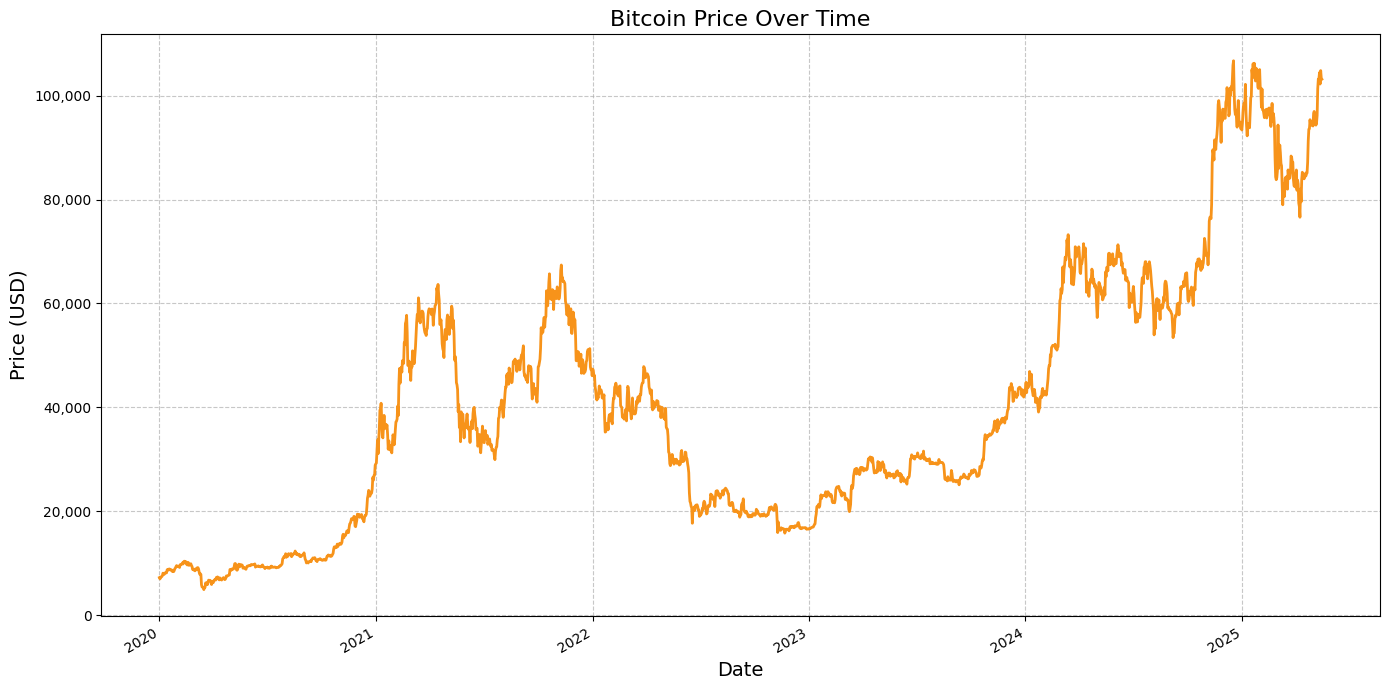

In [105]:
# Create a line chart for date vs BTC price
import matplotlib.pyplot as plt
import pandas as pd

# Make sure the date column is in datetime format
df = merged_bitcoin_fg_df.copy()
df['date'] = pd.to_datetime(df['date'])

# Sort the data by date to ensure proper line plotting
df = df.sort_values('date')

# Create the chart
plt.figure(figsize=(14, 7))
plt.plot(df['date'], df['market_close_price'], linewidth=2, color='#F7931A')  # Bitcoin orange color

# Add labels and title
plt.title('Bitcoin Price Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price (USD)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

# Format y-axis with commas for thousands
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))

# Improve x-axis date formatting
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()


In [106]:
import matplotlib.pyplot as plt

# Sample data for demonstration (replace this with your actual DataFrame)
# yearly_sentiment_counts = pd.DataFrame({
#     'year': [2020, 2020, 2021, 2021],
#     'value_classification': ['Fear', 'Greed', 'Fear', 'Greed'],
#     'count': [10, 15, 20, 25]
# })

# Create a bar plot
plt.figure(figsize=(12, 6))

# Create a bar for each sentiment classification per year
for sentiment in yearly_sentiment_counts['value_classification'].unique():
    subset = yearly_sentiment_counts[yearly_sentiment_counts['value_classification'] == sentiment]
    plt.bar(subset['year'], subset['count'], label=sentiment)

# Add titles and labels
plt.title('Count of Sentiments by Year', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(title='Sentiment', fontsize=12)

# Show the plot
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to make room for the rotated labels
plt.show()

KeyError: 'value_classification'

<Figure size 1200x600 with 0 Axes>

In [91]:
fig = plot_data_with_fear_greed_alerts(merged_bitcoin_fg_df, "BTC")
fig.show()

KeyError: 'daily_avg_price'

In [116]:
bitcoin_df_daily_week_change.head(20)

,date,market_open_price,market_open_timestamp,market_close_price,market_close_timestamp,avg_price,daily_high,daily_low,daily_price_change,market_price_change,updated_at,value_classification,value,weekday,monday_price,friday_price,monday_to_friday_change
1960,2020-01-01,7227.387335,2020-01-01 09:30:00,7225.101696,2020-01-01 16:00:00,7211.125160,7254.429873,7125.152370,0.0181,0.00,2025-04-11 18:34:18.313693,Fear,37,2,None,None,None
1959,2020-01-02,7131.805589,2020-01-02 09:30:00,6974.341707,2020-01-02 16:00:00,7058.630462,7251.232459,6883.969317,0.0534,-0.02,2025-04-11 18:34:18.313693,Fear,39,3,None,None,None
1958,2020-01-03,7282.933343,2020-01-03 09:30:00,7341.397841,2020-01-03 16:00:00,7319.430753,7419.441087,7190.387870,0.0319,0.01,2025-04-11 18:34:18.313693,Fear,38,4,None,None,None
1957,2020-01-04,7319.853070,2020-01-04 09:30:00,7356.610698,2020-01-04 16:00:00,7364.079198,7498.818613,7294.673903,0.0280,0.01,2025-04-11 18:34:18.313693,Fear,38,5,None,None,None
1956,2020-01-05,7457.075552,2020-01-05 09:30:00,7412.029871,2020-01-05 16:00:00,7448.937953,7587.371204,7331.078222,0.0350,-0.01,2025-04-11 18:34:18.313693,Fear,39,6,None,None,None
1955,2020-01-06,7535.158085,2020-01-06 09:30:00,7583.165035,2020-01-06 16:00:00,7632.528600,7987.468001,7507.657908,0.0639,0.01,2025-04-11 18:34:18.313693,Fear,41,0,7535.158085,8098.891545,0.074814
1954,2020-01-07,7881.244061,2020-01-07 09:30:00,8080.410342,2020-01-07 16:00:00,8023.152129,8452.834600,7752.151393,0.0904,0.03,2025-04-11 18:34:18.313693,Fear,40,1,None,None,None
1953,2020-01-08,8289.023642,2020-01-08 09:30:00,8014.109875,2020-01-08 16:00:00,8158.400919,8408.268125,7882.123648,0.0668,-0.03,2025-04-11 18:34:18.313693,Neutral,51,2,None,None,None
1952,2020-01-09,7889.157371,2020-01-09 09:30:00,7831.930562,2020-01-09 16:00:00,7860.504746,7999.295934,7758.079025,0.0311,-0.01,2025-04-11 18:34:18.313693,Fear,44,3,None,None,None
1951,2020-01-10,7910.565669,2020-01-10 09:30:00,8098.891545,2020-01-10 16:00:00,7968.330051,8244.787450,7681.686329,0.0733,0.02,2025-04-11 18:34:18.313693,Fear,41,4,None,None,None


In [117]:
def create_pivot_table_with_buckets_with_year(df, column_names, bins):
    """
    Creates a pivot table grouped by years with specified buckets for given columns.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing the data
    column_names (list): List of column names to create buckets for
    bins (list): List of bin edges for bucketing the data
    
    Returns:
    pd.DataFrame: Pivot table with counts and percentages by year and market sentiment
    """
    # Initialize empty DataFrame for pivot table
    pivot_table = pd.DataFrame()

    for column in column_names:
        # Create bucket column
        df[f'{column}_bucket'] = pd.cut(df[column], bins=bins, include_lowest=True)
        df[f'{column}_bucket'] = df[f'{column}_bucket'].astype(str)

        # Group by year, market_sentiment, and bucket
        bucket_counts = df.groupby(['year', 'market_sentiment',f'{column}_bucket']).size().reset_index(name=f'{column}_count')

        # Calculate percentages within each year and market_sentiment group
        yearly_sentiment_totals = bucket_counts.groupby(['year'])[f'{column}_count'].sum()
        bucket_counts[f'{column}_percentage'] = bucket_counts.apply(
            lambda x: (x[f'{column}_count'] / yearly_sentiment_totals[(x['year'])]) * 100, 
            axis=1
        )

        # Merge into pivot table
        if pivot_table.empty:
            pivot_table = bucket_counts
        else:
            pivot_table = pd.merge(
                pivot_table, 
                bucket_counts, 
                on=['year', 'market_sentiment', f'{column}_bucket'], 
                how='inner'
            )

    # Sort by year and market_sentiment
    pivot_table = pivot_table.sort_values(['year'])
    
    num_days = len(df)
    return pivot_table, num_days



# Example call
bins = [-0.5, -0.4,-0.3,-0.2, -0.15, -0.1, -0.05,0, 0.05, 0.1, 0.15, 0.2,0.3,0.4,0.5]  # Define your bin edges
pivot_table, num_days = create_pivot_table_with_buckets_with_year(merged_bitcoin_fg_df, ['market_price_change'], bins)



In [115]:
pivot_table, num_days = create_pivot_table_with_buckets_with_year(merged_bitcoin_fg_df, ['market_price_change'], bins)

In [118]:
# Filter out year 2019 from the pivot table
pivot_table = pivot_table[pivot_table['year'] != 2019]

# Display the filtered pivot table
pivot_table


,year,market_sentiment,market_price_change_bucket,market_price_change_count,market_price_change_percentage
0,2020,Bull,"(-0.05, 0.0]",221,60.382514
1,2020,Bull,"(-0.1, -0.05]",4,1.092896
2,2020,Bull,"(-0.15, -0.1]",1,0.273224
3,2020,Bull,"(0.0, 0.05]",138,37.704918
4,2020,Bull,"(0.05, 0.1]",2,0.546448
5,2021,Bull,"(-0.05, 0.0]",229,62.739726
6,2021,Bull,"(-0.1, -0.05]",8,2.191781
7,2021,Bull,"(-0.15, -0.1]",1,0.273973
8,2021,Bull,"(0.0, 0.05]",119,32.602740
9,2021,Bull,"(0.05, 0.1]",7,1.917808


In [119]:
def calculate_monday_to_friday_change(df):
    """
    Calculate the price change from Monday open to Friday close for each week.
    
    Args:
        df (DataFrame): DataFrame containing price data with a date column
        
    Returns:
        DataFrame: The input DataFrame with added columns for monday_price, 
                  friday_price, and monday_to_friday_change
    """
    # Make a copy to avoid modifying the original DataFrame
    result_df = df.copy()

    # Ensure the date column is of datetime type

    result_df['date'] = pd.to_datetime(result_df['date'])

    # Sort the DataFrame in ascending order based on the date column
    result_df = result_df.sort_values(by='date', ascending=True)
    
    # Extract the weekday (0=Monday, 4=Friday)
    result_df['weekday'] = result_df['date'].dt.weekday
    
    # Initialize new columns for the price change between Monday and Friday
    result_df['monday_price'] = None
    result_df['friday_price'] = None
    result_df['monday_to_friday_change'] = None
    
    # Iterate through the DataFrame to calculate the price change
    for i in range(len(result_df) - 4):
        if result_df.iloc[i]['weekday'] == 0:  # If it's a Monday
            # print(result_df.iloc[i])
            monday_price = result_df.iloc[i]['market_open_price']
            friday_price = result_df.iloc[i+4]['market_close_price']
            price_change = (friday_price - monday_price) / monday_price
            
            # Use .loc instead of direct assignment to avoid SettingWithCopyWarning
            result_df.loc[result_df.index[i], 'monday_price'] = monday_price
            result_df.loc[result_df.index[i], 'friday_price'] = friday_price
            result_df.loc[result_df.index[i], 'monday_to_friday_change'] = price_change
            
            # Also set the values for the Friday row if needed
            # result_df.loc[result_df.index[i+4], 'monday_price'] = monday_price
            # result_df.loc[result_df.index[i+4], 'friday_price'] = friday_price
            # result_df.loc[result_df.index[i+4], 'monday_to_friday_change'] = price_change
    
    # Drop the 'weekday' column if needed
    # result_df.drop(columns=['weekday'], inplace=True)
    
    return result_df

# Calculate Monday to Friday changes
bitcoin_df_daily_week_change = calculate_monday_to_friday_change(merged_bitcoin_fg_df)


In [120]:
bitcoin_df_daily_week_change.iloc[0]

date                                 2020-01-01 00:00:00
market_open_price                            7227.387335
market_open_timestamp                2020-01-01 09:30:00
market_close_price                           7225.101696
market_close_timestamp               2020-01-01 16:00:00
avg_price                                     7211.12516
daily_high                                   7254.429873
daily_low                                     7125.15237
daily_price_change                                0.0181
market_price_change                                  0.0
updated_at                    2025-04-11 18:34:18.313693
value_classification                                Fear
value                                                 37
market_price_change_bucket                  (-0.05, 0.0]
year                                                2020
market_sentiment                                    Bull
weekday                                                2
monday_price                   

In [121]:
bitcoin_df_daily_week_change.head(20)

,date,market_open_price,market_open_timestamp,market_close_price,market_close_timestamp,avg_price,daily_high,daily_low,daily_price_change,market_price_change,updated_at,value_classification,value,market_price_change_bucket,year,market_sentiment,weekday,monday_price,friday_price,monday_to_friday_change
0,2020-01-01,7227.387335,2020-01-01 09:30:00,7225.101696,2020-01-01 16:00:00,7211.125160,7254.429873,7125.152370,0.0181,0.00,2025-04-11 18:34:18.313693,Fear,37,"(-0.05, 0.0]",2020,Bull,2,None,None,None
1,2020-01-02,7131.805589,2020-01-02 09:30:00,6974.341707,2020-01-02 16:00:00,7058.630462,7251.232459,6883.969317,0.0534,-0.02,2025-04-11 18:34:18.313693,Fear,39,"(-0.05, 0.0]",2020,Bull,3,None,None,None
2,2020-01-03,7282.933343,2020-01-03 09:30:00,7341.397841,2020-01-03 16:00:00,7319.430753,7419.441087,7190.387870,0.0319,0.01,2025-04-11 18:34:18.313693,Fear,38,"(0.0, 0.05]",2020,Bull,4,None,None,None
3,2020-01-04,7319.853070,2020-01-04 09:30:00,7356.610698,2020-01-04 16:00:00,7364.079198,7498.818613,7294.673903,0.0280,0.01,2025-04-11 18:34:18.313693,Fear,38,"(0.0, 0.05]",2020,Bull,5,None,None,None
4,2020-01-05,7457.075552,2020-01-05 09:30:00,7412.029871,2020-01-05 16:00:00,7448.937953,7587.371204,7331.078222,0.0350,-0.01,2025-04-11 18:34:18.313693,Fear,39,"(-0.05, 0.0]",2020,Bull,6,None,None,None
5,2020-01-06,7535.158085,2020-01-06 09:30:00,7583.165035,2020-01-06 16:00:00,7632.528600,7987.468001,7507.657908,0.0639,0.01,2025-04-11 18:34:18.313693,Fear,41,"(0.0, 0.05]",2020,Bull,0,7535.158085,8098.891545,0.074814
6,2020-01-07,7881.244061,2020-01-07 09:30:00,8080.410342,2020-01-07 16:00:00,8023.152129,8452.834600,7752.151393,0.0904,0.03,2025-04-11 18:34:18.313693,Fear,40,"(0.0, 0.05]",2020,Bull,1,None,None,None
7,2020-01-08,8289.023642,2020-01-08 09:30:00,8014.109875,2020-01-08 16:00:00,8158.400919,8408.268125,7882.123648,0.0668,-0.03,2025-04-11 18:34:18.313693,Neutral,51,"(-0.05, 0.0]",2020,Bull,2,None,None,None
8,2020-01-09,7889.157371,2020-01-09 09:30:00,7831.930562,2020-01-09 16:00:00,7860.504746,7999.295934,7758.079025,0.0311,-0.01,2025-04-11 18:34:18.313693,Fear,44,"(-0.05, 0.0]",2020,Bull,3,None,None,None
9,2020-01-10,7910.565669,2020-01-10 09:30:00,8098.891545,2020-01-10 16:00:00,7968.330051,8244.787450,7681.686329,0.0733,0.02,2025-04-11 18:34:18.313693,Fear,41,"(0.0, 0.05]",2020,Bull,4,None,None,None


In [122]:
# Drop rows with None values in 'monday_friday_change' column
# num_of_week = len(merged_bitcoin_fg_df) / 7
filtered_df = bitcoin_df_daily_week_change.dropna(subset=['monday_to_friday_change'])

bins = [-0.5, -0.4,-0.3,-0.2, -0.15, -0.1, -0.05,0, 0.05, 0.1, 0.15, 0.2,0.3,0.4,0.5]  # Define your bin edges
weekly_pivot_table, num_of_week = create_pivot_table_with_buckets_with_year(filtered_df, ['monday_to_friday_change'], bins)
print(f"Number of weeks: {num_of_week}")
weekly_pivot_table
# weekly_pivot_table.to_csv('weekly_pivot_table.csv', index=False)

Number of weeks: 279


/var/folders/xl/nbd4ft0j4c3120jl664htp4m0000gn/T/ipykernel_92076/846449983.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/xl/nbd4ft0j4c3120jl664htp4m0000gn/T/ipykernel_92076/846449983.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,year,market_sentiment,monday_to_friday_change_bucket,monday_to_friday_change_count,monday_to_friday_change_percentage
0,2020,Bull,"(-0.05, 0.0]",12,23.076923
1,2020,Bull,"(-0.1, -0.05]",3,5.769231
2,2020,Bull,"(-0.15, -0.1]",2,3.846154
3,2020,Bull,"(-0.4, -0.3]",1,1.923077
4,2020,Bull,"(0.0, 0.05]",13,25.000000
5,2020,Bull,"(0.05, 0.1]",13,25.000000
6,2020,Bull,"(0.1, 0.15]",5,9.615385
7,2020,Bull,"(0.15, 0.2]",1,1.923077
8,2020,Bull,"(0.2, 0.3]",2,3.846154
17,2021,Bull,"(0.2, 0.3]",1,1.923077


/var/folders/xl/nbd4ft0j4c3120jl664htp4m0000gn/T/ipykernel_92076/2980940395.py:47: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



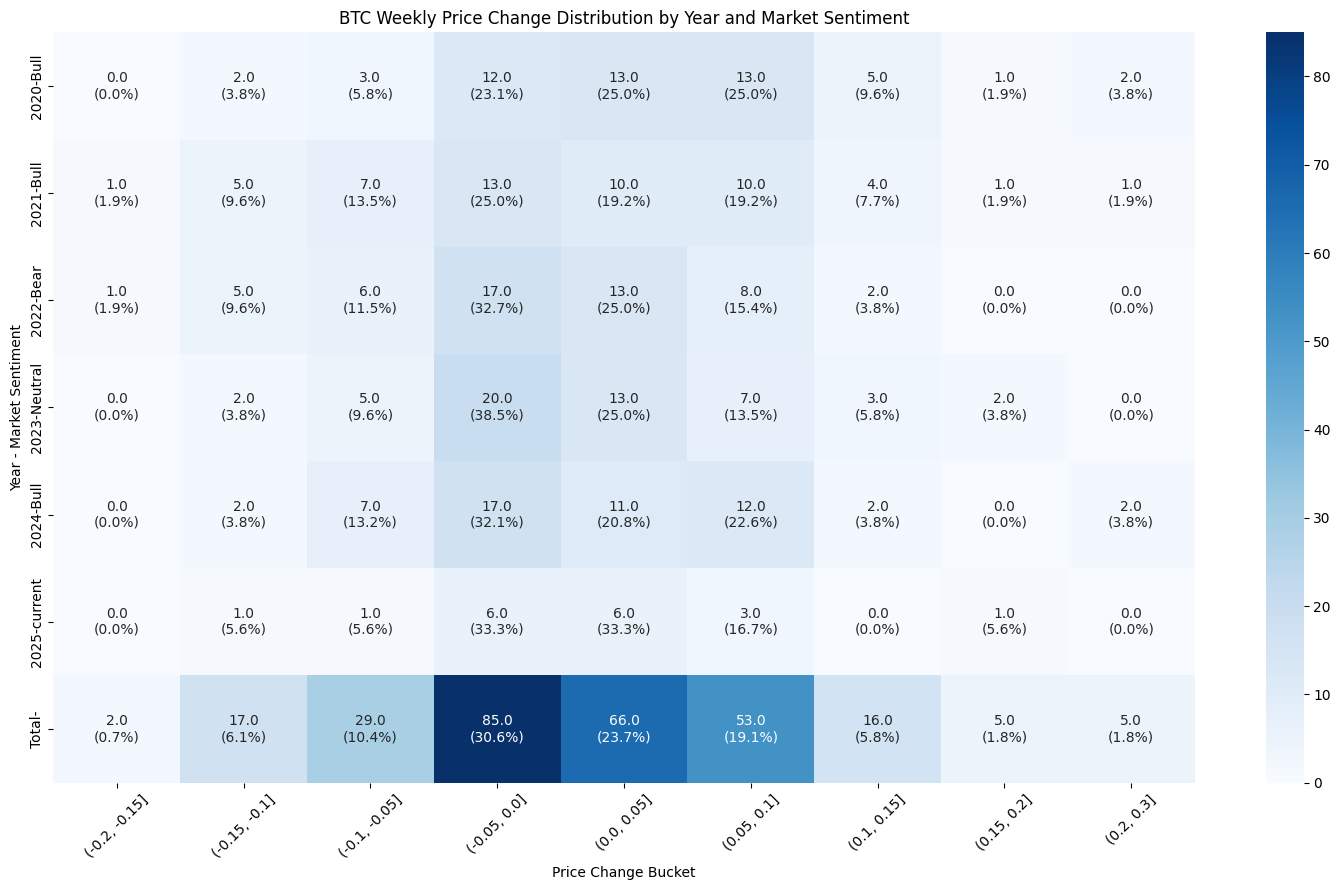

In [124]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the correct order of buckets
bucket_order = [
    '(-0.2, -0.15]',
    '(-0.15, -0.1]',
    '(-0.1, -0.05]',
    '(-0.05, 0.0]',
    '(0.0, 0.05]',
    '(0.05, 0.1]',
    '(0.1, 0.15]',
    '(0.15, 0.2]',
    '(0.2, 0.3]'
]

# Create pivot tables for both count and percentage
count_pivot = pd.pivot_table(
    weekly_pivot_table,
    values='monday_to_friday_change_count',
    index=['year', 'market_sentiment'],
    columns='monday_to_friday_change_bucket',
    fill_value=0
)

percent_pivot = pd.pivot_table(
    weekly_pivot_table,
    values='monday_to_friday_change_percentage',
    index=['year', 'market_sentiment'],
    columns='monday_to_friday_change_bucket',
    fill_value=0
)

# Reorder the columns
count_pivot = count_pivot[bucket_order]
percent_pivot = percent_pivot[bucket_order]

# Calculate totals
total_counts = count_pivot.sum()
total_percentages = (total_counts / total_counts.sum() * 100)

# Add totals as a new row with just 'Total' as the label
count_pivot.loc[('Total', ''), :] = total_counts
percent_pivot.loc[('Total', ''), :] = total_percentages

# Create annotation text combining count and percentage
annotations = count_pivot.applymap(str) + '\n(' + percent_pivot.applymap(lambda x: f'{x:.1f}%') + ')'

# Create heatmap
plt.figure(figsize=(15, 9))
sns.heatmap(count_pivot, annot=annotations, fmt='', cmap='Blues')
plt.title('BTC Weekly Price Change Distribution by Year and Market Sentiment')
plt.xlabel('Price Change Bucket')
plt.ylabel('Year - Market Sentiment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [233]:
pivot_table.head(20)

,year,market_sentiment,market_price_change_bucket,market_price_change_count,market_price_change_percentage
1,2020,Bull,"(-0.05, 0.0]",143,39.071038
2,2020,Bull,"(-0.1, -0.05]",3,0.819672
3,2020,Bull,"(-0.15, -0.1]",1,0.273224
4,2020,Bull,"(0.0, 0.05]",213,58.196721
5,2020,Bull,"(0.05, 0.1]",6,1.639344
6,2021,Bull,"(-0.05, 0.0]",187,51.232877
7,2021,Bull,"(-0.1, -0.05]",8,2.191781
8,2021,Bull,"(-0.15, -0.1]",1,0.273973
9,2021,Bull,"(0.0, 0.05]",159,43.561644
10,2021,Bull,"(0.05, 0.1]",9,2.465753


/var/folders/xl/nbd4ft0j4c3120jl664htp4m0000gn/T/ipykernel_92076/37844447.py:46: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



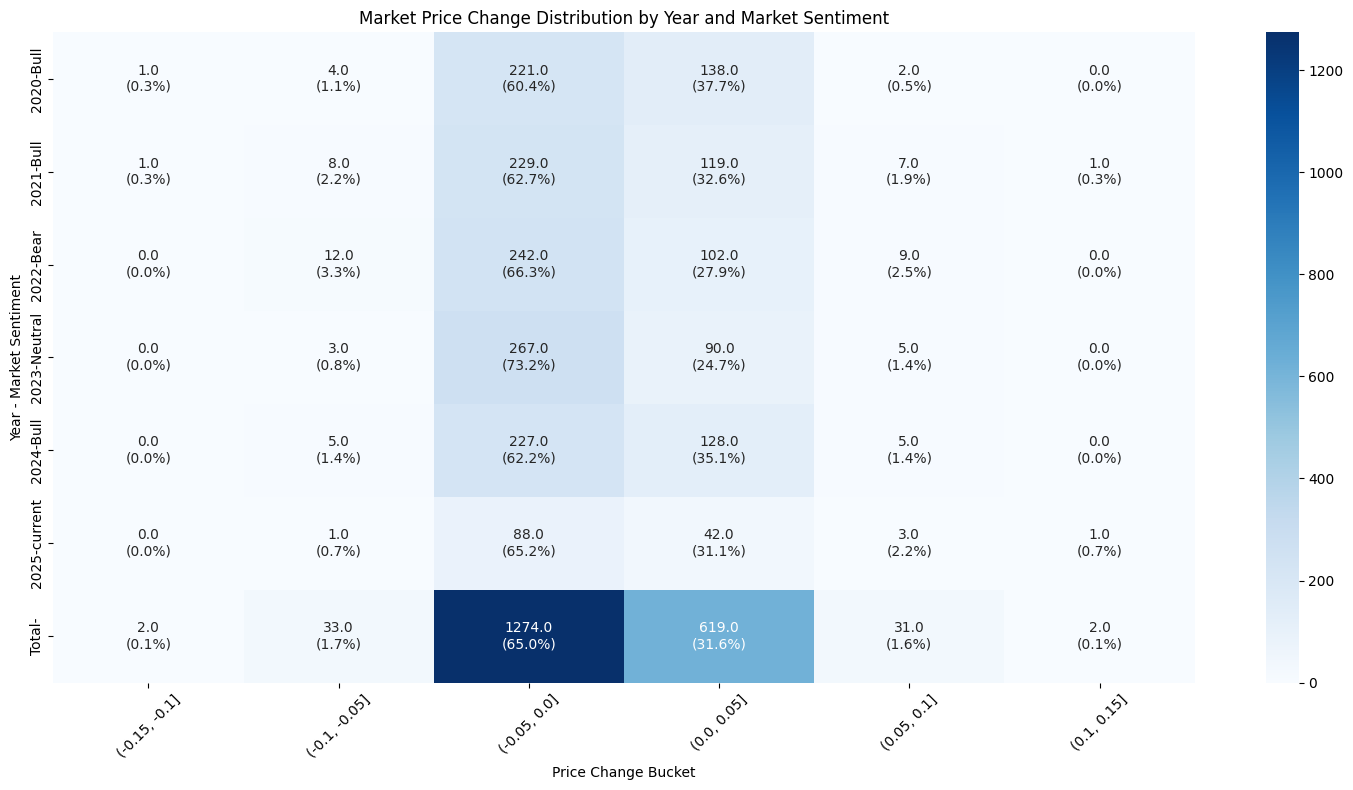

In [125]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the correct order of buckets
bucket_order = [

    '(-0.15, -0.1]',
    '(-0.1, -0.05]',
    '(-0.05, 0.0]',
    '(0.0, 0.05]',
    '(0.05, 0.1]',
    '(0.1, 0.15]'
]

# Create pivot tables for both count and percentage
count_pivot = pd.pivot_table(
    pivot_table,
    values='market_price_change_count',
    index=['year', 'market_sentiment'],
    columns='market_price_change_bucket',
    fill_value=0
)

percent_pivot = pd.pivot_table(
    pivot_table,
    values='market_price_change_percentage',
    index=['year', 'market_sentiment'],
    columns='market_price_change_bucket',
    fill_value=0
)

# Reorder the columns
count_pivot = count_pivot[bucket_order]
percent_pivot = percent_pivot[bucket_order]


# Calculate totals
total_counts = count_pivot.sum()
total_percentages = (total_counts / total_counts.sum() * 100)

# Add totals as a new row with just 'Total' as the label
count_pivot.loc[('Total', ''), :] = total_counts
percent_pivot.loc[('Total', ''), :] = total_percentages

# Create annotation text combining count and percentage
annotations = count_pivot.applymap(str) + '\n(' + percent_pivot.applymap(lambda x: f'{x:.1f}%') + ')'

# Create heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(count_pivot, annot=annotations, fmt='', cmap='Blues')
plt.title('Market Price Change Distribution by Year and Market Sentiment')
plt.xlabel('Price Change Bucket')
plt.ylabel('Year - Market Sentiment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [126]:
def analyze_consecutive_weeks(df):
    """
    Analyze two consecutive weeks' price movements using monday_price and friday_price.
    """
    # Make sure data is sorted by date
    df = df.copy()

    df = df.sort_values('date')
    df.dropna(subset=['monday_to_friday_change'], inplace=True)
    
    # Create a list to store results
    results = []
    
    # Loop through the data to find consecutive weeks
    for i in range(len(df)-1):
        # Get current week data
        week1 = df.iloc[i]
        
        # Get next week data
        week2 = df.iloc[i+1]
        
        # Calculate price changes
        # For week 1: from monday_price to friday_price
        week1_change = (week1['friday_price'] - week1['monday_price']) / week1['monday_price']
            
        # For week 2: from monday_price to friday_price
        week2_change = (week2['friday_price'] - week2['monday_price']) / week2['monday_price']

        # Check if both weeks moved in the same direction
        if (week1_change > 0 and week2_change > 0) or (week1_change < 0 and week2_change < 0):
            # Calculate total change
            week1_start = week1['monday_price']
            week2_end = week2['friday_price']
            total_change = ((week2_end - week1_start) / week1_start)
            
            results.append({
                'week1_monday_date': week1['date'], # You might want to adjust this based on your data
                'week2_monday_date': week2['date'],
                'week1_monday_price': week1_start,
                'week1_friday_price': week1['friday_price'],
                'week2_monday_price': week2['monday_price'], 
                'week2_friday_price': week2_end,
                'week1_change_pct': week1_change,
                'week2_change_pct': week2_change,
                'total_change_pct': total_change,
                'direction': 'increase' if week1_change > 0 else 'decrease'
            })
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    return results_df

# Run the analysis
consecutive_weeks = analyze_consecutive_weeks(bitcoin_df_daily_week_change)

consecutive_weeks

# # Visualization
# plt.figure(figsize=(12, 6))
# plt.scatter(consecutive_weeks['week1_change_pct'], 
#            consecutive_weeks['week2_change_pct'],
#            c=consecutive_weeks['direction'].map({'increase': 'green', 'decrease': 'red'}),
#            alpha=0.6)
# plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
# plt.axvline(x=0, color='k', linestyle='--', alpha=0.3)
# plt.xlabel('Week 1 Change (%)')
# plt.ylabel('Week 2 Change (%)')
# plt.title('Consecutive Weeks Price Movement Pattern')
# plt.grid(True, alpha=0.3)
# plt.show()

,week1_monday_date,week2_monday_date,week1_monday_price,week1_friday_price,week2_monday_price,week2_friday_price,week1_change_pct,week2_change_pct,total_change_pct,direction
0,2020-01-06,2020-01-13,7535.158085,8098.891545,8068.451045,8868.691034,0.074814,0.099181,0.176975,increase
1,2020-01-27,2020-02-03,8745.152383,9321.234611,9341.641782,9751.314449,0.065874,0.043854,0.115054,increase
2,2020-02-03,2020-02-10,9341.641782,9751.314449,9828.887354,10360.988917,0.043854,0.054137,0.109119,increase
3,2020-02-10,2020-02-17,9828.887354,10360.988917,9492.692683,9679.191460,0.054137,0.019647,-0.015230,increase
4,2020-03-16,2020-03-23,4549.154573,5868.518285,6262.526509,6654.507301,0.290024,0.062591,0.462801,increase
...,...,...,...,...,...,...,...,...,...,...
141,2025-02-24,2025-03-03,95484.149755,84209.088833,93161.405717,86957.272955,-0.118083,-0.066596,-0.089301,decrease
142,2025-03-10,2025-03-17,82649.815581,84057.119614,82919.908932,84065.406205,0.017027,0.013815,0.017128,increase
143,2025-03-31,2025-04-07,82538.279920,83755.057756,76813.250326,83920.311042,0.014742,0.092524,0.016744,increase
144,2025-04-21,2025-04-28,87200.392829,95374.973358,95105.728906,96963.203753,0.093745,0.019531,0.111958,increase


In [127]:
# Add market sentiment information to consecutive weeks data
consecutive_weeks['market_sentiment'] = 'Bull->Bull'  # Default value

# For recent data (2025), mark as current->current
current_year = 2025
consecutive_weeks.loc[consecutive_weeks['week1_monday_date'].dt.year >= current_year, 'market_sentiment'] = 'current->current'

# Get top 5 increases and decreases for each year
def get_top_movements_by_year(df):
    results = []
    
    # Group by year
    for year, year_data in df.groupby(df['week1_monday_date'].dt.year):
        # Get top 5 increases
        top_increases = year_data[year_data['direction'] == 'increase'].nlargest(5, 'total_change_pct')
        for _, row in top_increases.iterrows():
            results.append({
                'year': year,
                'week1_date': row['week1_monday_date'],
                'week2_date': row['week2_monday_date'],
                'week1_price': row['week1_monday_price'],
                'week2_price': row['week2_friday_price'],
                'total_change_pct': row['total_change_pct'],
                'movement_type': 'Top Increase'
            })
        
        # Get top 5 decreases (largest negative changes)
        top_decreases = year_data[year_data['direction'] == 'decrease'].nsmallest(5, 'total_change_pct')
        for _, row in top_decreases.iterrows():
            results.append({
                'year': year,
                'week1_date': row['week1_monday_date'],
                'week2_date': row['week2_monday_date'],
                'week1_price': row['week1_monday_price'],
                'week2_price': row['week2_friday_price'],
                'total_change_pct': row['total_change_pct'],
                'movement_type': 'Top Decrease'
            })
    
    return pd.DataFrame(results)

# Get top movements for each year
top_movements = get_top_movements_by_year(consecutive_weeks)

top_movements


,year,week1_date,week2_date,week1_price,week2_price,total_change_pct,movement_type
0,2020,2020-03-16,2020-03-23,4549.154573,6654.507301,0.462801,Top Increase
1,2020,2020-12-28,2021-01-04,27225.798113,39648.488964,0.456284,Top Increase
2,2020,2020-04-27,2020-05-04,7650.044298,9951.891235,0.300893,Top Increase
3,2020,2020-12-21,2020-12-28,22742.631154,29273.528628,0.287165,Top Increase
4,2020,2020-12-14,2020-12-21,19096.758810,24278.632366,0.271348,Top Increase
5,2020,2020-08-24,2020-08-31,11784.893405,10562.383527,-0.103735,Top Decrease
6,2020,2020-11-30,2020-12-07,19260.387350,17968.108256,-0.067095,Top Decrease
7,2020,2020-08-17,2020-08-24,12039.048653,11503.251666,-0.044505,Top Decrease
8,2020,2020-08-10,2020-08-17,11893.635150,11704.770078,-0.015880,Top Decrease
9,2020,2020-07-06,2020-07-13,9265.443721,9163.859882,-0.010964,Top Decrease


Consecutive Weeks Count by Year:


,Year,Count
0,2020,28
1,2021,31
2,2022,27
3,2023,24
4,2024,28
5,2025,5


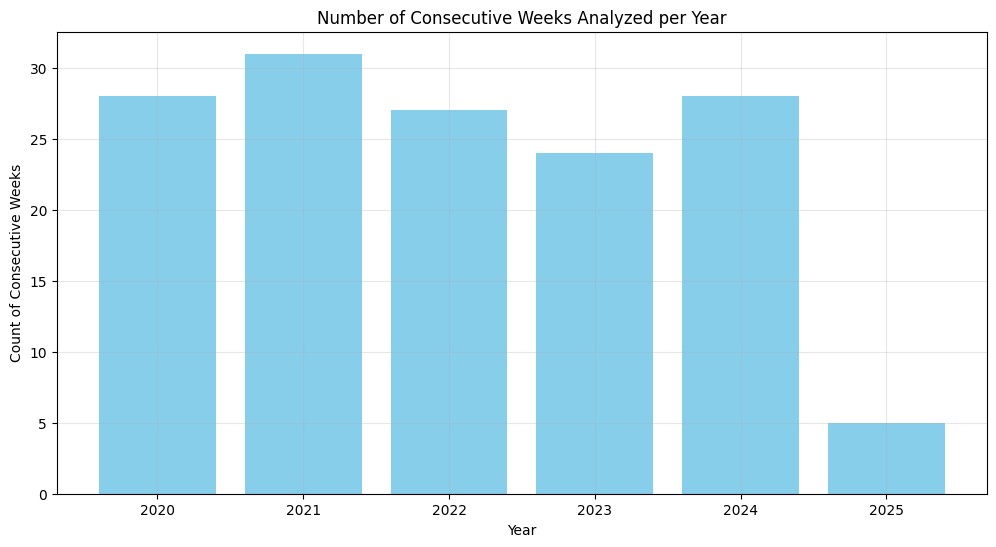

In [98]:
# Count consecutive weeks for each year
yearly_counts = consecutive_weeks.groupby(consecutive_weeks['week1_monday_date'].dt.year).size().reset_index()
yearly_counts.columns = ['Year', 'Count']

# Display the counts
print("Consecutive Weeks Count by Year:")
display(yearly_counts)

# Visualize the counts
plt.figure(figsize=(12, 6))
plt.bar(yearly_counts['Year'], yearly_counts['Count'], color='skyblue')
plt.xlabel('Year'asd
           
           asd
           
           
           
           plt.ylabel('Count of Consecutive Weeks'4

           as
           \


           asdasdasdasd
t.title('Number of Consecutive Weeks Analyzed per Year')
plt.xticks(yearly_counts['Year'])
plt.grid(True, alpha=0.3)
plt.show()


In [134]:
import yfinance as yf

# Get MSTR data
mstr = yf.Ticker("MSTR")

# Get historical data
# start and end are optional, default is max available data
mstr_data = mstr.history(
    start="2025-01-01",
    # end="2024-02-14",
    interval="1d"
)






YFRateLimitError: Too Many Requests. Rate limited. Try after a while.

In [13]:
bitcoin_df_daily.head(20)

,date,market_open_price,market_open_timestamp,market_close_price,market_close_timestamp,avg_price,daily_high,daily_low,daily_price_change,market_price_change,updated_at
0,2025-04-10,81696.952495,2025-04-10 09:30:00.000,79555.613960,2025-04-10 16:00:00.000,80709.979660,82357.628952,78410.422602,0.0503,-0.03,2025-04-11 15:38:56.610082
1,2025-04-09,76789.077850,2025-04-09 09:30:00.000,82047.676938,2025-04-09 16:00:00.000,79486.938194,83569.037346,74953.377315,0.1149,0.07,2025-04-11 15:38:56.610082
2,2025-04-08,80150.470729,2025-04-08 09:30:00.000,76599.683702,2025-04-08 16:00:00.000,77944.304869,80379.249166,74569.723261,0.0779,-0.04,2025-04-11 15:38:56.610082
3,2025-04-07,76813.250326,2025-04-07 09:29:59.700,78644.449420,2025-04-07 16:00:00.000,78014.509811,81127.987680,74416.741606,0.0902,0.02,2025-04-11 15:38:56.610082
4,2025-04-06,82501.920762,2025-04-06 09:30:00.000,79326.988191,2025-04-06 16:00:00.000,81057.415655,83500.435484,77092.143274,0.0831,-0.04,2025-04-11 15:38:56.610082
5,2025-04-05,82802.030647,2025-04-05 09:30:00.000,83014.201044,2025-04-05 16:00:00.000,83247.314673,83870.844666,82348.467883,0.0185,0.00,2025-04-11 18:34:18.313693
6,2025-04-04,82576.489664,2025-04-04 09:29:59.900,83755.057756,2025-04-04 16:00:00.000,83505.263383,84710.364543,81654.351729,0.0374,0.01,2025-04-11 18:34:18.313693
7,2025-04-03,81973.101703,2025-04-03 09:30:00.000,81780.769071,2025-04-03 16:00:00.000,82702.666266,83766.984563,81180.828886,0.0319,0.00,2025-04-11 18:34:18.313693
8,2025-04-02,84624.319387,2025-04-02 09:30:00.000,85696.751369,2025-04-02 16:00:00.000,84805.950214,88477.013394,82162.931558,0.0768,0.01,2025-04-11 18:34:18.313693
9,2025-04-01,83663.661359,2025-04-01 09:29:59.900,84965.966196,2025-04-01 16:00:00.000,84409.296513,85547.438370,82525.947158,0.0366,0.02,2025-04-11 18:34:18.313693
